In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
directory = "/kaggle/input/procedural-environment-generation/dataset/dataset"
img_shape = (256,256,1)
img_paths = [directory + '/' + file for file in os.listdir(directory)]
img_paths = img_paths[:-6]
img_paths = np.sort(img_paths)

In [3]:
def load_images(img_paths):
    for image in img_paths:
        img = Image.open(image)
        img_array = np.array(img)
        img_array_normalized = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array))
        
        yield np.transpose(np.expand_dims(np.float32(img_array_normalized), axis = 2),(2,0,1))

In [4]:
def show_images(imgs, grid_size=5):
    fig = plt.figure(figsize = (9,9))
    plt.axis("off")
    plt.title("sample training images")
    images = load_images(imgs)
    columns = rows = grid_size
    for i in range(1, columns*rows +1):
        
        fig.add_subplot(rows, columns, i)
        plt.axis("off")
        plt.imshow(np.transpose(next(images), (1,2,0)), cmap = 'gray')
        
    plt.show()

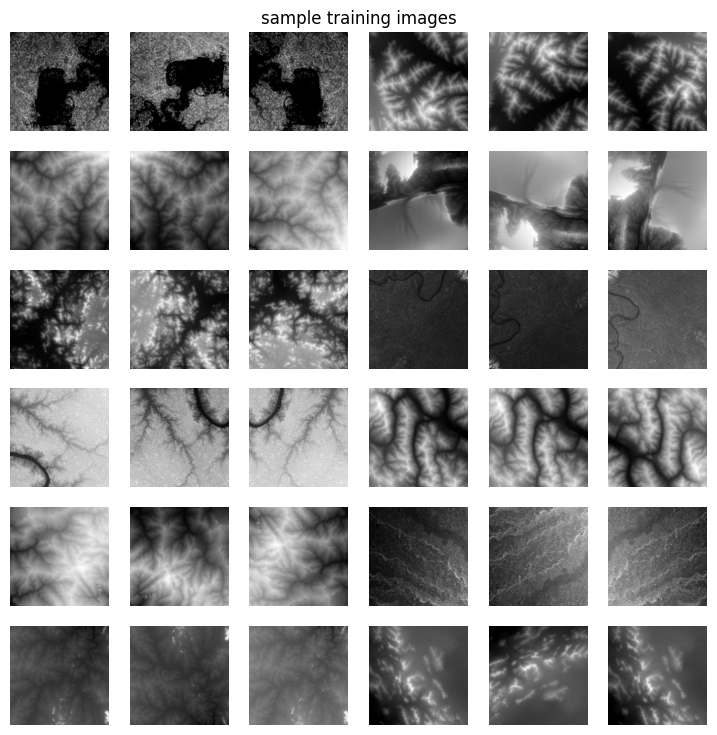

In [5]:
show_images(img_paths,6)

In [6]:
class Terrain(Dataset):
    def __init__(self, img_paths):
        self.img_paths = img_paths
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = next(load_images([self.img_paths[idx]]))
        return image

In [7]:
dataset = Terrain(img_paths)
batchsize = 64
shuffle = True

In [8]:
Batches = DataLoader(dataset = dataset, batch_size = batchsize, shuffle = shuffle)

In [9]:
dev = 'cuda:0' if torch.cuda.is_available() == True else 'cpu'
device = torch.device(dev)
print(dev)

cuda:0


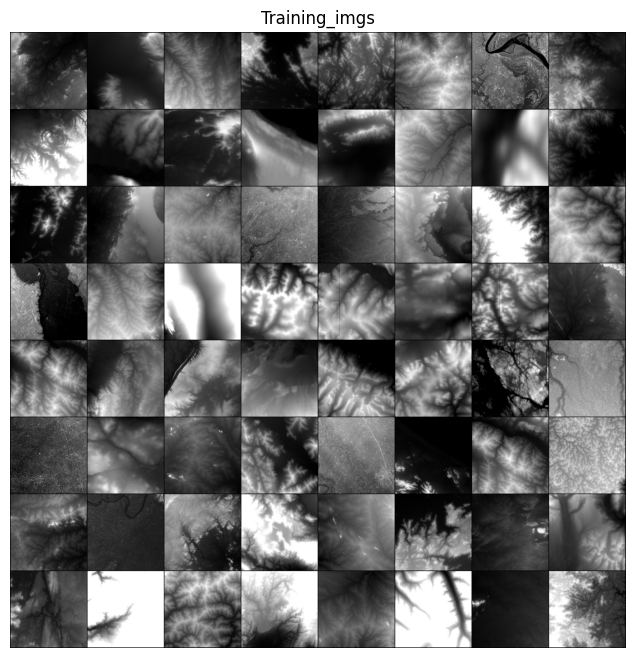

In [10]:
import torchvision.utils as vutils
batch = next(iter(Batches))
plt.figure(figsize = (8,8))
plt.axis("off")
plt.title("Training_imgs")
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding = 2, normalize=True).cpu(),(1,2,0)), cmap='gray')
plt.show()

In [11]:
class VAE(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.mean_layer = nn.Linear(256 * (256 // 16) * (256 // 16), latent_dim)
        self.log_var_layer = nn.Linear(256 * (256 // 16) * (256 // 16), latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * (256 // 16) * (256 // 16)),
            nn.ReLU(),
            nn.Unflatten(1, (256, 256 // 16, 256 // 16)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        mean = self.mean_layer(x)
        log_var = self.log_var_layer(x)

        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mean + eps * std

        x_reconstructed = self.decoder(z)

        return x_reconstructed, mean, log_var, z

In [12]:
class GAN(nn.Module):
    def __init__(self, latent_dim):
        super(GAN, self).__init__()

        # Generator
        self.generator = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256 * (256 // 16) * (256 // 16)),
            nn.ReLU(),
            nn.Unflatten(1, (256, 256 // 16, 256 // 16)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        # Discriminator
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * (256 // 16) * (256 // 16), 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        fake_images = self.generator(z)
        discriminator_output = self.discriminator(fake_images)
        return fake_images, discriminator_output

    

In [13]:
checkpoint_dir = 'model_checkpoints_real'
os.makedirs(checkpoint_dir, exist_ok=True)

In [14]:
input_channels = 1  # Assuming grayscale height maps
latent_dim = 64
learning_rate_vae = 3e-4
learning_rate_gan = 3e-5
num_epochs = 25
gamma = 15

# Create VAE and GAN models, loss functions, and optimizers
vae = VAE(input_channels, latent_dim).to(device)
gan = GAN(latent_dim).to(device)
criterion_vae = nn.MSELoss().to(device)
criterion_gan = nn.BCELoss().to(device)
optim_E = optim.Adam(vae.parameters(), lr=learning_rate_vae)
optim_D = optim.Adam(vae.parameters(), lr=learning_rate_vae)
optim_Dis = optim.Adam(gan.parameters(), lr=learning_rate_gan)

In [ ]:
for epoch in range(num_epochs):
    prior_loss_list,gan_loss_list,recon_loss_list=[],[],[]
    dis_real_list,dis_fake_list,dis_prior_list=[],[],[]
    for i, (data) in enumerate(Batches):
        inputs = data.to(device)
        rec_enc, mean, logvar, z = vae(inputs)
        z_p = torch.randn(64,64).to(device) #creating some random input noise
        x_p_tilda = vae.decoder(z_p)
        
        #training the discriminator 
        output_real = gan.discriminator(inputs)    #with the real images
        errD_real = criterion_gan(output_real,torch.ones_like(output_real))
        dis_real_list.append(errD_real.item())
        
        output_fake = gan.discriminator(rec_enc)   #with the reconstructed images from our encoder
        errD_fake = criterion_gan(output_fake,torch.zeros_like(output_fake))
        dis_fake_list.append(errD_fake.item())
        
        output_noise = gan.discriminator(x_p_tilda)  #with the images constructed from the noise
        errD_rec_noise = criterion_gan(output_noise,torch.zeros_like(output_noise))
        dis_prior_list.append(errD_rec_noise.item())
        
        gan_loss = errD_real + errD_fake + errD_rec_noise
        gan_loss_list.append(gan_loss.item())
        optim_Dis.zero_grad()
        gan_loss.backward(retain_graph=True)
        optim_Dis.step()
        
        #training the decoder
        rec_loss = criterion_vae(output_fake, output_real)
        err_dec = gamma * rec_loss - gan_loss 
        recon_loss_list.append(rec_loss.item())
        optim_D.zero_grad()
        err_dec.backward(retain_graph=True)
        optim_D.step()
        
        #training the encoder
        prior_loss = 1 + logvar - mean.pow(2) - logvar.exp()  
        prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean.data)   #kl divergence
        prior_loss_list.append(prior_loss.item())
        err_enc = prior_loss + 5*rec_loss

        optim_E.zero_grad()
        err_enc.backward(retain_graph=True)
        optim_E.step()

        if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_gan: %.4f\tLoss_prior: %.4f\tRec_loss: %.4f\tdis_real_loss: %0.4f\tdis_fake_loss: %.4f\tdis_prior_loss: %.4f'
                      % (epoch,num_epochs, i, len(Batches),
                         gan_loss.item(), prior_loss.item(),rec_loss.item(),errD_real.item(),errD_fake.item(),errD_rec_noise.item()))
    with torch.no_grad():
        vae.eval()
        gan.eval()
        z_extracted = z
        generated_height_map = vae.decoder(z_extracted.to(device)).squeeze().detach()
    
    generated_height_map_np = (generated_height_map * 255).clamp(0, 255).cpu().numpy()
    for i in range(3):
            image_name = f'generated_image_epoch_{epoch + 1}_sample_{i + 1}.png'
            image_path = os.path.join(checkpoint_dir, image_name)
            plt.imsave(image_path, generated_height_map_np[i], cmap='gray')

    
    plt.figure(figsize=(10, 10))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(generated_height_map_np[i], cmap='gray')
        plt.axis('off')
        plt.suptitle(f'Generated Images - Epoch {epoch + 1}')
        plt.show()
    
    # Save model checkpoints
    checkpoint_vae = {
        'epoch': epoch,
        'model_state_dict': vae.state_dict(),
        'optimizer_E_dict': optim_E.state_dict(),
        'optimizer_D_dict': optim_D.state_dict(),
        'prior loss': prior_loss,
        'rec loss': rec_loss,
        
    }
    torch.save(checkpoint_vae, os.path.join(checkpoint_dir, f'vae_checkpoint_epoch_{epoch + 1}.pth'))

    checkpoint_gan = {
        'epoch': epoch,
        'model_state_dict': gan.state_dict(),
        'gan_loss': gan_loss,
        'optimizer_state_dict_dis': optim_Dis.state_dict(),
        'errD_Real': errD_real,
        'errD_Fake': errD_fake,
        'errD_rec_noise': errD_rec_noise
        
    }
    torch.save(checkpoint_gan, os.path.join(checkpoint_dir, f'gan_checkpoint_epoch_{epoch + 1}.pth'))

    
    

    
    
    

In [ ]:
def plot_loss(loss_list):
    plt.figure(figsize=(10,5))
    plt.title("Loss During Training")
    plt.plot(loss_list,label="Loss")
    
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
plot_loss(prior_loss_list)
plot_loss(recon_loss_list)
plot_loss(gan_loss_list)

In [18]:
# Load VAE model
checkpoint_input = '/kaggle/input/vae-gan-1'
checkpoint_vae = torch.load(os.path.join(checkpoint_input, 'model_checkpoints_real/vae_checkpoint_epoch_25.pth'))

# Initialize VAE model
vae = VAE(input_channels, latent_dim).to(device)

# Load state_dict into the model
vae.load_state_dict(checkpoint_vae['model_state_dict'])

# Load optimizer states
optim_E = optim.Adam(vae.parameters(), lr=learning_rate_vae)
optim_D = optim.Adam(vae.parameters(), lr=learning_rate_vae)
optim_E.load_state_dict(checkpoint_vae['optimizer_E_dict'])
optim_D.load_state_dict(checkpoint_vae['optimizer_D_dict'])

# Additional information
prior_loss = checkpoint_vae['prior loss']
rec_loss = checkpoint_vae['rec loss']

In [19]:
checkpoint_gan = torch.load(os.path.join(checkpoint_input, 'model_checkpoints_real/gan_checkpoint_epoch_25.pth'))

# Initialize GAN model
gan = GAN(latent_dim).to(device)

# Load state_dict into the model
gan.load_state_dict(checkpoint_gan['model_state_dict'])

# Load optimizer states
optim_Dis = optim.Adam(gan.parameters(), lr=learning_rate_gan)
optim_Dis.load_state_dict(checkpoint_gan['optimizer_state_dict_dis'])

# Additional information
gan_loss = checkpoint_gan['gan_loss']
errD_Real = checkpoint_gan['errD_Real']
errD_Fake = checkpoint_gan['errD_Fake']
errD_rec_noise = checkpoint_gan['errD_rec_noise']

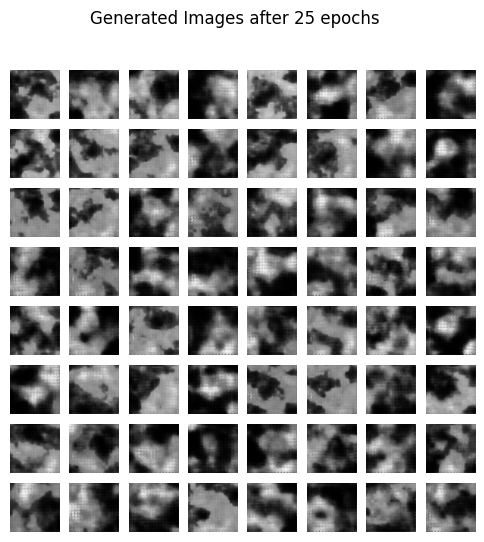

In [27]:
with torch.no_grad():
        vae.eval()
        gan.eval()
        batch = next(iter(Batches))
        inputs = batch.to(device)
        rec_enc, mean, logvar, z = vae(inputs)
        generated_height_maps = vae.decoder(z.to(device)).squeeze().detach()

generated_height_maps_np = (generated_height_maps * 255).clamp(0, 255).cpu().numpy() 
generated_height_maps_np_grid = generated_height_maps_np.reshape(8, 8, 256, 256)  # Assuming height and width are the dimensions of each image

plt.figure(figsize=(6,6))
for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, i*8 + j + 1)
        plt.imshow(generated_height_maps_np_grid[i, j], cmap='gray')
        plt.axis('off')
plt.suptitle('Generated Images after 25 epochs')
plt.show()